# Import packages

In [101]:
import sys

sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import glob

# Import data

In [102]:
from membranequant.funcs import load_image, direcslist

path = '../test_datasets/dataset2_par2_neon/'
paths = direcslist(path, 0)

images = [load_image(glob.glob(p + '/af_corrected.tif')[0]) for p in paths]
rois = [np.loadtxt(glob.glob(p + '/*ROI*')[0]) for p in paths]

# Straighten/Preprocess images

In [103]:
from membranequant.funcs import straighten, rolling_ave_2d, interp_2d_array

rol_ave = 20
thickness = 50
periodic = True
nfits = 500

def preprocess(straight, rol_ave=rol_ave, bg_subtract=bg_subtract):
    # Smoothen
    straight_filtered = rolling_ave_2d(straight, window=20, periodic=periodic)
    
    # Interpolate
    straight_filtered_itp = interp_2d_array(straight_filtered, nfits, ax=0, method='cubic')

    # Normalise
    norm = np.max(straight_filtered_itp)
    target = straight_filtered_itp / norm
    
    return target, norm

target, norms = zip(*[preprocess(straighten(img, roi, thickness)) for img, roi in zip(images, rois)])
target = np.array(target)

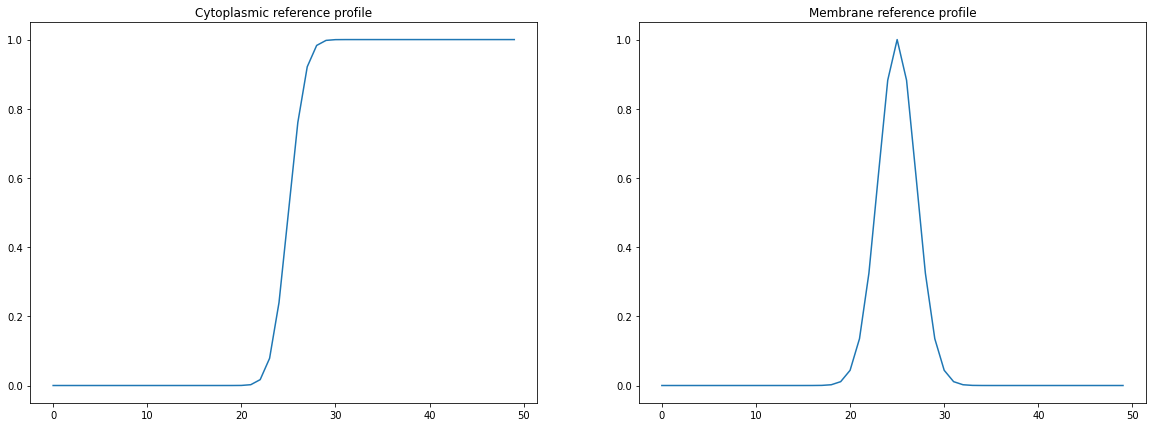

In [104]:
from scipy.special import erf

sigma = 2
thickness = 50
cytbg = (1 + erf((np.arange(thickness) - thickness / 2) / sigma)) / 2
membg = np.exp(-((np.arange(thickness) - thickness / 2) ** 2) / (2 * sigma ** 2))

sigma = 5
thickness = 50
cytbg2 = (1 + erf((np.arange(thickness) - thickness / 2) / sigma)) / 2
membg2 = np.exp(-((np.arange(thickness) - thickness / 2) ** 2) / (2 * sigma ** 2))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(cytbg)
ax2.plot(membg)
ax1.set_title('Cytoplasmic reference profile')
ax2.set_title('Membrane reference profile')
plt.gcf().set_size_inches(20,7)

### Set up model

In [105]:
import tensorflow as tf
import tensorflow_probability as tfp

thickness = 50

def sim_images(cyts, mems, offsets, cytbg=cytbg, membg=membg, thickness=thickness):
    nimages = mems.shape[0]
    nfits = mems.shape[1]
    
    # Normalise curves
    membg_norm = membg / tf.reduce_max(membg)
    cytbg_norm = cytbg / tf.reduce_max(cytbg)
    
    # Need to align peak to centre - how?
    # First: approximate peak position, and deviation from centre
    # Next: subtract/add offsets from deviation?
    
    # Positions to evaluate mem and cyt curves 
    positions_ = np.arange(thickness, dtype=np.float64)[tf.newaxis, tf.newaxis, :]
    offsets_ = offsets[:, :, tf.newaxis]
    positions = tf.reshape(tf.math.add(positions_, offsets_), [-1])
                           
    # Mem curve
    mem_curve = tfp.math.interp_regular_1d_grid(y_ref=membg_norm, x_ref_min=0, x_ref_max=1, x=positions / thickness)
    mem_curve = tf.reshape(mem_curve, [nimages, nfits, thickness])

    # Cyt curve
    cyt_curve = tfp.math.interp_regular_1d_grid(y_ref=cytbg_norm, x_ref_min=0, x_ref_max=1, x=positions / thickness)
    cyt_curve = tf.reshape(cyt_curve, [nimages, nfits, thickness])

    # Calculate output
    mem_total = mem_curve * tf.expand_dims(mems, axis=-1)
    cyt_total = cyt_curve * tf.expand_dims(tf.expand_dims(cyts, axis=-1), axis=-1)
    return tf.transpose(tf.math.add(mem_total, cyt_total), [0, 2, 1])

def loss_function(target_images, cyts, mems, offsets, cytbg=cytbg, membg=membg):
    return tf.math.reduce_mean((sim_images(cyts, mems, offsets, cytbg=cytbg, membg=membg) - target_images) ** 2)

### Initialise parameters

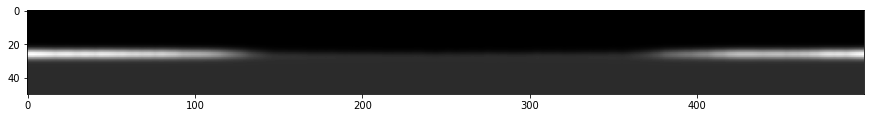

In [106]:
def init_params(target):
    nimages = target.shape[0]
    nfits = target.shape[2]
    
    offsets = tf.Variable(np.zeros([nimages, nfits]))
    cyts = tf.Variable(np.mean(target[:, -5:, :], axis=(1, 2)))
    mems = tf.Variable(np.max(target, axis=1) - 0.5 * cyts[:, np.newaxis])
    return cyts, mems, offsets

%matplotlib inline
plt.imshow(sim_images(*init_params(target))[0], cmap='gray')
plt.gcf().set_size_inches(15,15)

### Optimise parameters by gradient descent

Works a bit better with lower learning rate and longer training

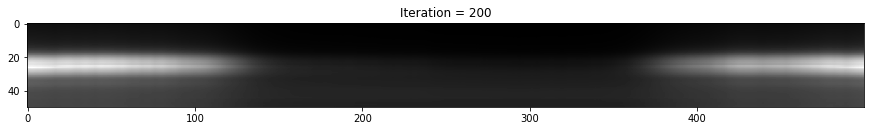

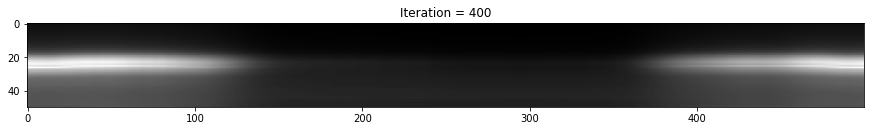

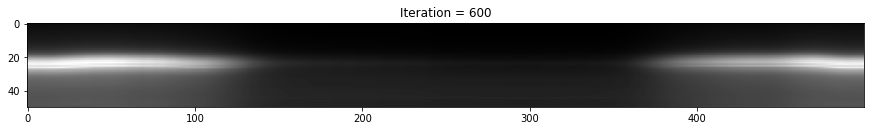

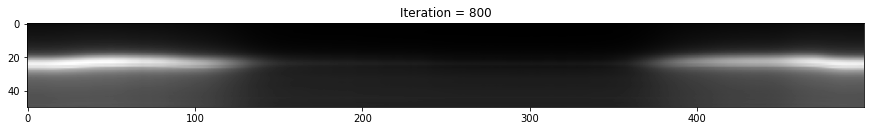

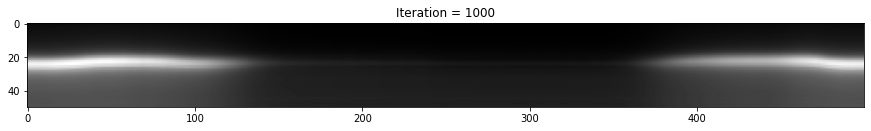

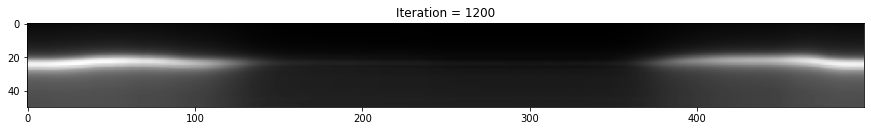

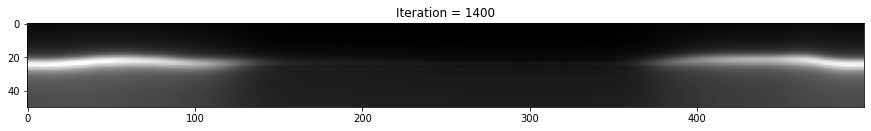

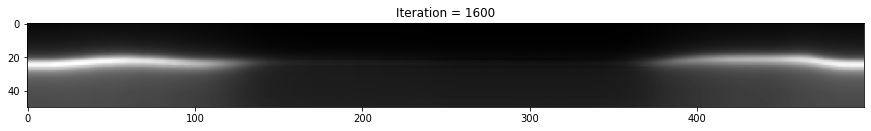

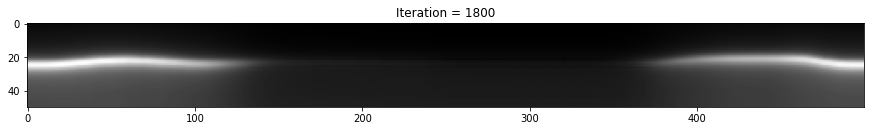

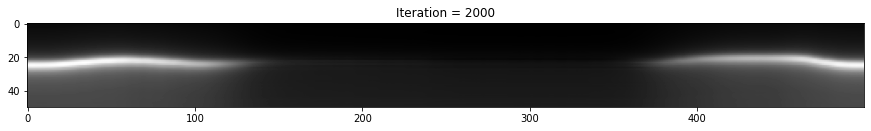

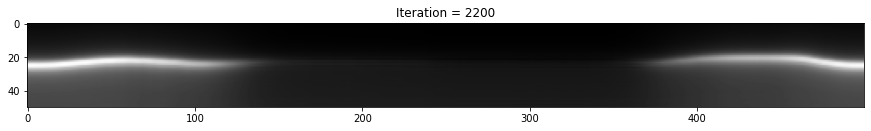

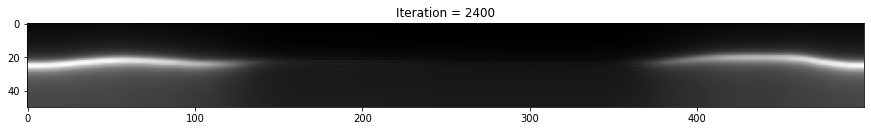

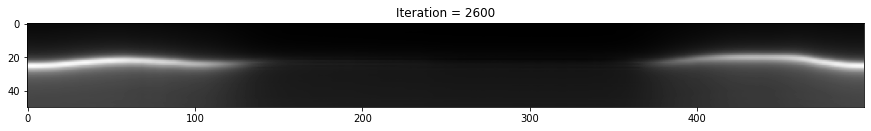

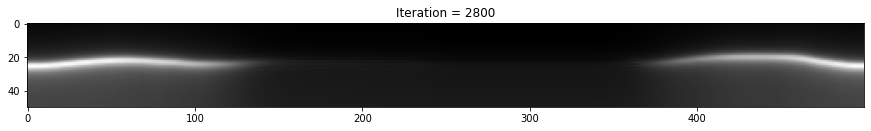

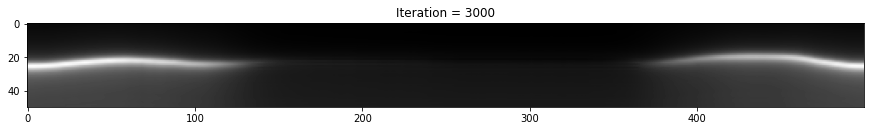

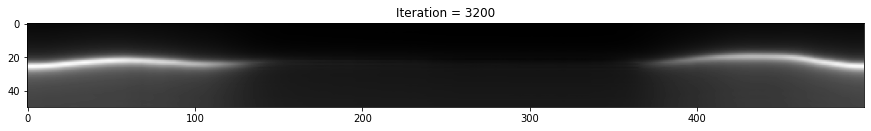

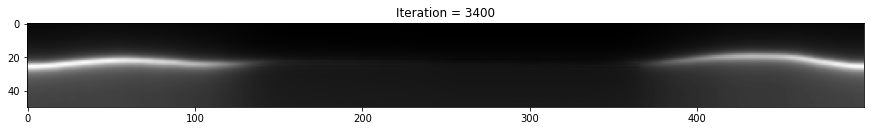

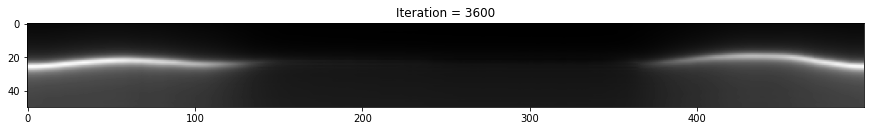

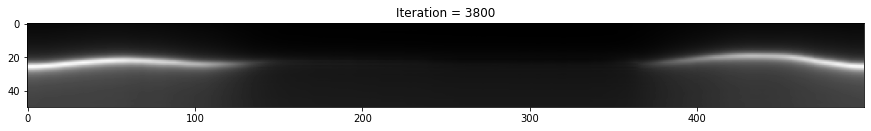

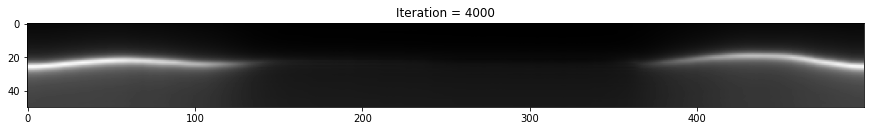

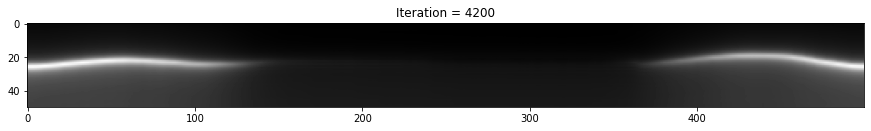

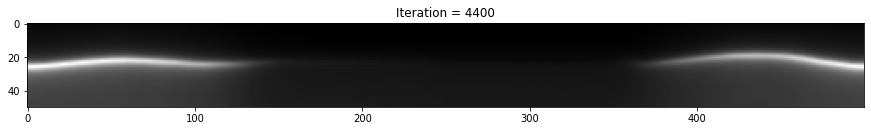

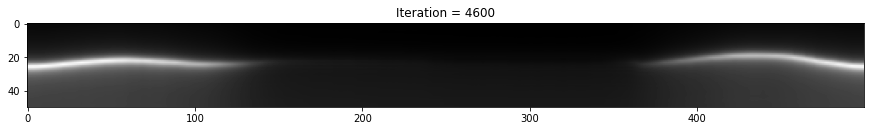

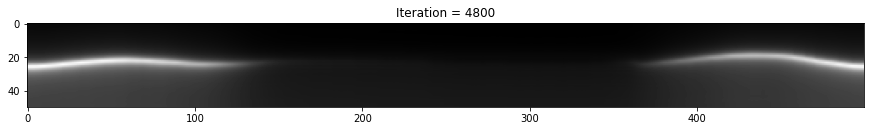

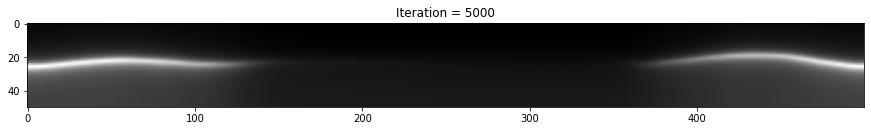

In [120]:
lr = 0.001
iterations = 5000

def optimise(target, lr=lr, iterations=iterations):
    
    # Init parameters
    cyts, mems, offsets = init_params(target)
    cytbg = tf.Variable(cytbg2)
    membg = tf.Variable(membg2)
    
    # Gradient descent
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    losses = np.zeros(iterations)
    for i in range(iterations):   
        with tf.GradientTape() as tape:
            loss = loss_function(target, cyts, mems, offsets, cytbg=cytbg, membg=membg) 
            losses[i] = loss
            var_list = [offsets, cyts, mems, cytbg, membg] 
            grads = tape.gradient(loss, var_list)
            opt.apply_gradients(list(zip(grads, var_list)))
        
        # Plot fit
        if (i + 1) % 200 == 0: 
            plt.imshow(sim_images(cyts, mems, offsets, cytbg=cytbg, membg=membg)[0], cmap='gray')
            plt.title('Iteration = ' + str(i + 1))
            plt.gcf().set_size_inches(15,15)
            plt.show()
            
    return cyts, mems, offsets, cytbg / tf.reduce_max(cytbg), membg / tf.reduce_max(membg), losses
            
%matplotlib inline
cyts, mems, offsets, cytbg, membg, losses = optimise(target)

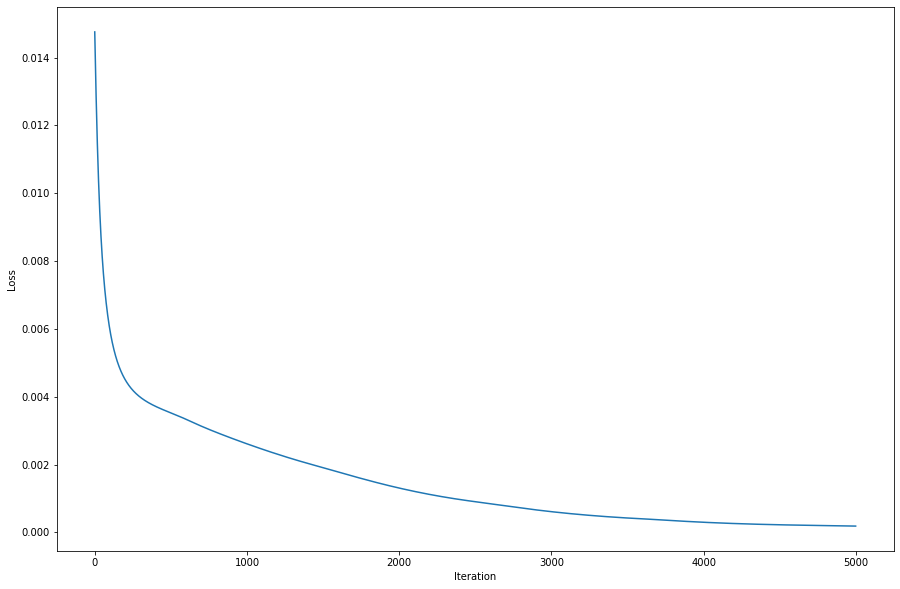

In [121]:
%matplotlib inline
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15,10)

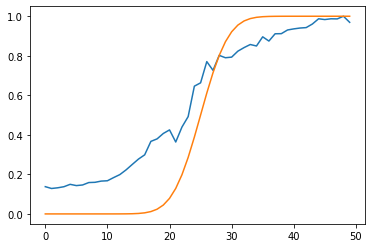

In [122]:
plt.plot(cytbg.numpy())
plt.plot(cytbg2)

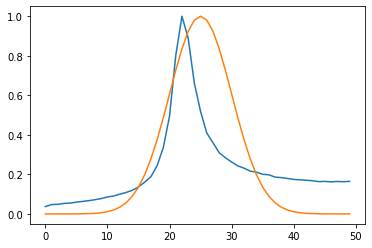

In [123]:
plt.plot(membg.numpy())
plt.plot(membg2)

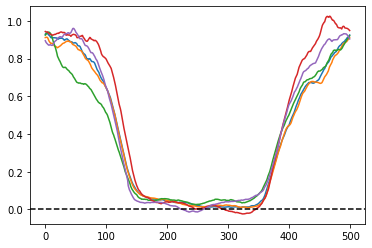

In [124]:
plt.plot(mems.numpy().T)
plt.axhline(0, c='k', linestyle='--')

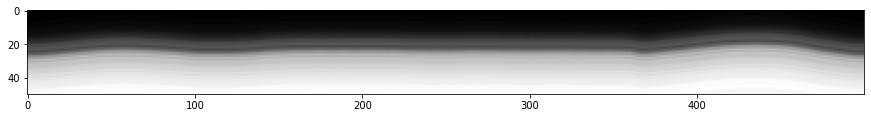

In [125]:
cyt_component = sim_images(cyts, mems * 0, offsets, cytbg=cytbg, membg=membg, thickness=thickness)
plt.imshow(cyt_component[0], cmap='gray')
plt.gcf().set_size_inches(15,15)

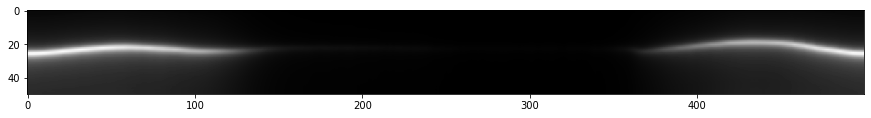

In [126]:
mem_component = sim_images(cyts * 0, mems, offsets, cytbg=cytbg, membg=membg, thickness=thickness)
plt.imshow(mem_component[0], cmap='gray')
plt.gcf().set_size_inches(15,15)